w did it omi

In [ ]:
# Install required packages
!pip install ctgan pandas numpy faker matplotlib seaborn


In [27]:

# Import necessary libraries
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from faker import Faker
from ctgan import CTGAN
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
fake = Faker()
Faker.seed(42)

print("Creating a new dataset with controlled data types...")

# Define the number of samples for seed data
num_samples = 5000
fraud_ratio = 0.4
num_fraud = int(num_samples * fraud_ratio)
num_legit = num_samples - num_fraud

# Create a new DataFrame with controlled data types
new_data = pd.DataFrame()

# Generate transaction IDs (will be excluded from training)
new_data['transaction_id'] = [f"T{i+1:08d}" for i in range(num_samples)]

# Generate timestamps
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = (end_date - start_date).days
new_data['timestamp'] = [
    (start_date + timedelta(days=random.randint(0, date_range))).strftime('%Y-%m-%d %H:%M:%S')
    for _ in range(num_samples)
]

# Generate account numbers (as integers to avoid string issues)
new_data['customer_account_number'] = [random.randint(10000, 99999) for _ in range(num_samples)]
new_data['to_recipient_customer_account'] = [random.randint(10000, 99999) for _ in range(num_samples)]

# Generate numeric fields
new_data['old_balance'] = [round(random.uniform(1000, 100000), 2) for _ in range(num_samples)]
new_data['transaction_amount'] = [round(random.uniform(100, 50000), 2) for _ in range(num_samples)]
new_data['new_balance'] = new_data['old_balance'] - new_data['transaction_amount']
new_data['tp_recipient_customer_account_balance'] = [round(random.uniform(1000, 100000), 2) for _ in range(num_samples)]
new_data['transaction_time_in_ms'] = [random.randint(100, 5000) for _ in range(num_samples)]
new_data['transaction_frequency'] = [random.randint(1, 30) for _ in range(num_samples)]
new_data['average_transaction_amount'] = [round(random.uniform(100, 10000), 2) for _ in range(num_samples)]
new_data['account_age_days'] = [random.randint(30, 3650) for _ in range(num_samples)]

# Generate categorical fields
new_data['method_of_transaction'] = [random.choice(['RTGS', 'IMPS', 'UPI', 'DIRECT_TRANSFER', 'NEFT']) for _ in range(num_samples)]
new_data['transaction_currency'] = [random.choice(['INR', 'USD', 'EUR', 'GBP']) for _ in range(num_samples)]
new_data['location_data'] = [random.choice(['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata', 'Hyderabad', 'Pune', 'Ahmedabad']) for _ in range(num_samples)]
new_data['device_used'] = [random.choice(['MOBILE_APP', 'WEB_BROWSER', 'BRANCH', 'ATM', 'PHONE_BANKING']) for _ in range(num_samples)]
new_data['kyc_status'] = [random.choice(['FULL', 'PARTIAL', 'MINIMAL', 'PENDING']) for _ in range(num_samples)]

# Generate binary fields
new_data['label_for_fraud'] = [0] * num_samples
new_data['smurfing_indicator'] = [0] * num_samples
new_data['previous_fraud_flag'] = [0] * num_samples

# Then set fraud_ratio percentage to fraudulent
fraud_indices = random.sample(range(num_samples), num_fraud)
for idx in fraud_indices:
    new_data.loc[idx, 'label_for_fraud'] = 1
    # For fraudulent transactions, set higher probability of smurfing and previous fraud
    if random.random() < 0.3:  # 30% of fraud has smurfing
        new_data.loc[idx, 'smurfing_indicator'] = 1
    if random.random() < 0.4:  # 40% of fraud has previous fraud
        new_data.loc[idx, 'previous_fraud_flag'] = 1

# Check data types
print("\nData types of new dataset:")
print(new_data.dtypes)

# Save the new dataset
new_data.to_csv('ctgan_seed_transactions.csv', index=False)
print("Seed data saved to 'ctgan_seed_transactions.csv'")

# Create a copy of the data for CTGAN training
# We'll exclude problematic columns and convert categorical columns to category type
train_data = new_data.copy()

# Exclude columns that might cause issues
excluded_columns = ['transaction_id', 'timestamp']
train_data = train_data.drop(columns=excluded_columns)

# Convert categorical columns to category type
categorical_features = [
    'method_of_transaction',
    'transaction_currency',
    'location_data',
    'device_used',
    'kyc_status'
]

for col in categorical_features:
    train_data[col] = train_data[col].astype('category')

# Convert account numbers to categorical codes to avoid string issues
train_data['customer_account_number'] = train_data['customer_account_number'].astype('category').cat.codes
train_data['to_recipient_customer_account'] = train_data['to_recipient_customer_account'].astype('category').cat.codes

# Check data types after conversion
print("\nData types after conversion for CTGAN training:")
print(train_data.dtypes)

# Train the CTGAN model
print("\nTraining CTGAN model...")
ctgan = CTGAN(epochs=300, verbose=True)

# Fit the model
ctgan.fit(train_data, categorical_features)
print("CTGAN model training completed")

# Generate synthetic data in batches
print("\nGenerating synthetic data...")
num_records = 1000000  # 10 lakh records
batch_size = 200000  # Generate in batches to avoid memory issues

synthetic_data_batches = []
for i in range(0, num_records, batch_size):
    print(f"Generating batch {i//batch_size + 1}/{num_records//batch_size}...")
    batch = ctgan.sample(batch_size)
    synthetic_data_batches.append(batch)

# Combine all batches
synthetic_data = pd.concat(synthetic_data_batches, ignore_index=True)
print(f"Generated {len(synthetic_data)} synthetic transactions")


Creating a new dataset with controlled data types...

Data types of new dataset:
transaction_id                            object
timestamp                                 object
customer_account_number                    int64
to_recipient_customer_account              int64
old_balance                              float64
transaction_amount                       float64
new_balance                              float64
tp_recipient_customer_account_balance    float64
transaction_time_in_ms                     int64
transaction_frequency                      int64
average_transaction_amount               float64
account_age_days                           int64
method_of_transaction                     object
transaction_currency                      object
location_data                             object
device_used                               object
kyc_status                                object
label_for_fraud                            int64
smurfing_indicator                   

Gen. (-3.41) | Discrim. (-0.13): 100%|██████████| 300/300 [03:34<00:00,  1.40it/s]


CTGAN model training completed

Generating synthetic data...
Generating batch 1/5...
Generating batch 2/5...
Generating batch 3/5...
Generating batch 4/5...
Generating batch 5/5...
Generated 1000000 synthetic transactions


In [28]:
synthetic_data

,customer_account_number,to_recipient_customer_account,old_balance,transaction_amount,new_balance,tp_recipient_customer_account_balance,transaction_time_in_ms,transaction_frequency,average_transaction_amount,account_age_days,method_of_transaction,transaction_currency,location_data,device_used,kyc_status,label_for_fraud,smurfing_indicator,previous_fraud_flag
0,4359,1497,72246.127302,16350.673490,-8205.370043,-2356.300280,802,2,-406.799364,1394,DIRECT_TRANSFER,INR,Hyderabad,ATM,FULL,1,0,0
1,326,443,98012.246856,37595.736853,-22582.435890,36712.204434,1130,19,10076.036138,2690,RTGS,EUR,Hyderabad,ATM,PARTIAL,0,0,0
2,3563,4854,95356.070917,36365.594011,71669.397010,42124.005522,1644,19,4104.387962,1272,NEFT,USD,Ahmedabad,MOBILE_APP,PENDING,0,0,0
3,4090,3685,59525.283540,28292.289760,77791.766492,43841.845994,2548,12,7382.090633,961,NEFT,GBP,Hyderabad,MOBILE_APP,FULL,0,0,0
4,1642,1773,34334.205086,1609.793558,33573.136383,47009.658424,2698,26,934.571639,1193,DIRECT_TRANSFER,INR,Mumbai,PHONE_BANKING,FULL,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3986,4319,53730.264266,35646.586480,-18810.201551,68001.312992,1049,10,6265.780677,230,NEFT,INR,Mumbai,MOBILE_APP,MINIMAL,1,0,0
999996,3209,3900,47282.798743,41686.262089,-4924.617862,22483.186679,528,14,9552.301008,2101,NEFT,EUR,Chennai,ATM,MINIMAL,1,0,0
999997,3430,5134,67968.517925,12003.401088,-23386.088414,31673.383788,2093,30,3564.068660,334,NEFT,GBP,Hyderabad,BRANCH,MINIMAL,1,0,0
999998,1061,3135,82197.238916,45232.103651,80819.282670,51693.680392,2980,23,52.576096,322,RTGS,EUR,Chennai,WEB_BROWSER,PENDING,0,0,0


In [29]:

# Post-process the synthetic data
print("\nPost-processing synthetic data...")

# 1. Add back the excluded columns
synthetic_data['transaction_id'] = [f"T{i+1:08d}" for i in range(len(synthetic_data))]
synthetic_data['timestamp'] = [
    (start_date + timedelta(days=random.randint(0, date_range))).strftime('%Y-%m-%d %H:%M:%S')
    for _ in range(len(synthetic_data))
]

# 2. Convert categorical codes back to original values
# Create mappings from the original data
account_mapping = dict(enumerate(new_data['customer_account_number'].unique()))
recipient_mapping = dict(enumerate(new_data['to_recipient_customer_account'].unique()))

# Apply mappings
synthetic_data['customer_account_number'] = synthetic_data['customer_account_number'].apply(
    lambda x: account_mapping.get(int(x) % len(account_mapping), random.randint(10000, 99999))
)
synthetic_data['to_recipient_customer_account'] = synthetic_data['to_recipient_customer_account'].apply(
    lambda x: recipient_mapping.get(int(x) % len(recipient_mapping), random.randint(10000, 99999))
)

# 3. Ensure balances make sense (new_balance = old_balance - transaction_amount)
synthetic_data['transaction_amount'] = synthetic_data['transaction_amount'].abs()  # Ensure positive amounts
synthetic_data['new_balance'] = synthetic_data['old_balance'] - synthetic_data['transaction_amount']

# 4. Ensure binary fields are 0 or 1
for binary_field in ['label_for_fraud', 'smurfing_indicator', 'previous_fraud_flag']:
    synthetic_data[binary_field] = synthetic_data[binary_field].apply(lambda x: 1 if x >= 0.5 else 0)

# 5. Ensure fraud ratio is approximately 40%
current_fraud_count = synthetic_data['label_for_fraud'].sum()
current_fraud_ratio = current_fraud_count / len(synthetic_data)
print(f"Current fraud ratio: {current_fraud_ratio:.2%}")

# Adjust if needed to get closer to 40%
target_fraud_ratio = 0.4
if abs(current_fraud_ratio - target_fraud_ratio) > 0.05:
    if current_fraud_ratio < target_fraud_ratio:
        # Need more fraud transactions
        legit_indices = synthetic_data[synthetic_data['label_for_fraud'] == 0].index
        num_to_convert = int((target_fraud_ratio - current_fraud_ratio) * len(synthetic_data))
        convert_indices = np.random.choice(legit_indices, size=min(num_to_convert, len(legit_indices)), replace=False)
        synthetic_data.loc[convert_indices, 'label_for_fraud'] = 1
    else:
        # Need fewer fraud transactions
        fraud_indices = synthetic_data[synthetic_data['label_for_fraud'] == 1].index
        num_to_convert = int((current_fraud_ratio - target_fraud_ratio) * len(synthetic_data))
        convert_indices = np.random.choice(fraud_indices, size=min(num_to_convert, len(fraud_indices)), replace=False)
        synthetic_data.loc[convert_indices, 'label_for_fraud'] = 0
    
    # Verify the new ratio
    new_fraud_ratio = synthetic_data['label_for_fraud'].sum() / len(synthetic_data)
    print(f"Adjusted fraud ratio: {new_fraud_ratio:.2%}")

# Save the synthetic data
synthetic_data.to_csv('synthetic_transactions_1M.csv', index=False)
print("Synthetic data saved to 'synthetic_transactions_1M.csv'")


Post-processing synthetic data...
Current fraud ratio: 39.95%
Synthetic data saved to 'synthetic_transactions_1M.csv'


In [30]:


# Generate specific fraud scenarios
print("\nGenerating specific fraud scenarios...")

def generate_specific_fraud_scenarios(base_data, num_scenarios=5000):
    """Generate specific fraud scenarios to ensure coverage of different patterns"""
    
    # Define fraud scenarios
    scenarios = [
        "large_transaction",
        "smurfing",
        "unusual_time",
        "new_recipient",
        "unusual_location",
        "account_takeover",
        "identity_theft"
    ]
    
    specific_frauds = []
    
    for i in range(num_scenarios):
        # Copy a random fraud transaction as template
        template = base_data[base_data['label_for_fraud'] == 1].sample(1).iloc[0].to_dict()
        
        # Select a scenario
        scenario = random.choice(scenarios)
        
        # Modify the template based on the scenario
        if scenario == "large_transaction":
            template['transaction_amount'] = round(random.uniform(100000, 1000000), 2)
            template['smurfing_indicator'] = 0
            template['new_balance'] = template['old_balance'] - template['transaction_amount']
            
        elif scenario == "smurfing":
            template['transaction_amount'] = round(random.uniform(9000, 9999), 2)
            template['smurfing_indicator'] = 1
            template['new_balance'] = template['old_balance'] - template['transaction_amount']
            
        elif scenario == "unusual_time":
            hour = random.randint(0, 5)  # Very early morning
            dt = datetime.strptime(str(template['timestamp']), '%Y-%m-%d %H:%M:%S')
            template['timestamp'] = dt.replace(hour=hour).strftime('%Y-%m-%d %H:%M:%S')
            
        elif scenario == "new_recipient":
            template['to_recipient_customer_account'] = random.randint(100000, 999999)
            
        elif scenario == "unusual_location":
            unusual_locations = ["Foreign", "Unknown", "TOR_Exit_Node"]
            template['location_data'] = random.choice(unusual_locations)
            
        elif scenario == "account_takeover":
            template['device_used'] = random.choice(["NEW_DEVICE", "UNKNOWN_DEVICE"])
            
        elif scenario == "identity_theft":
            template['kyc_status'] = "SUSPICIOUS"
            template['previous_fraud_flag'] = 1
        
        # Ensure it's marked as fraud
        template['label_for_fraud'] = 1
        template['transaction_id'] = f"FS{i+1:07d}"  # Special ID for fraud scenarios
        
        specific_frauds.append(template)
    
    # Convert to DataFrame
    specific_fraud_df = pd.DataFrame(specific_frauds)
    
    return specific_fraud_df

# Generate specific fraud scenarios
specific_fraud_scenarios = generate_specific_fraud_scenarios(synthetic_data, num_scenarios=5000)
print(f"Generated {len(specific_fraud_scenarios)} specific fraud scenarios")

# Combine with main synthetic data
final_synthetic_data = pd.concat([synthetic_data, specific_fraud_scenarios], ignore_index=True)




Generating specific fraud scenarios...
Generated 5000 specific fraud scenarios


In [31]:
# Save the final dataset
final_synthetic_data.to_csv('final_synthetic_transactions.csv', index=False)
print(f"Final dataset with {len(final_synthetic_data)} records saved to 'final_synthetic_transactions.csv'")
print(f"Final fraud ratio: {final_synthetic_data['label_for_fraud'].mean():.2%}")



Final dataset with 1005000 records saved to 'final_synthetic_transactions.csv'
Final fraud ratio: 40.25%


In [32]:
final_synthetic_data

,customer_account_number,to_recipient_customer_account,old_balance,transaction_amount,new_balance,tp_recipient_customer_account_balance,transaction_time_in_ms,transaction_frequency,average_transaction_amount,account_age_days,method_of_transaction,transaction_currency,location_data,device_used,kyc_status,label_for_fraud,smurfing_indicator,previous_fraud_flag,transaction_id,timestamp
0,20917,61612,72246.127302,16350.673490,55895.453812,-2356.300280,802,2,-406.799364,1394,DIRECT_TRANSFER,INR,Hyderabad,ATM,FULL,1,0,0,T00000001,2023-08-09 00:00:00
1,20793,69546,98012.246856,37595.736853,60416.510002,36712.204434,1130,19,10076.036138,2690,RTGS,EUR,Hyderabad,ATM,PARTIAL,0,0,0,T00000002,2023-05-31 00:00:00
2,67627,21971,95356.070917,36365.594011,58990.476905,42124.005522,1644,19,4104.387962,1272,NEFT,USD,Ahmedabad,MOBILE_APP,PENDING,0,0,0,T00000003,2020-07-31 00:00:00
3,63546,72975,59525.283540,28292.289760,31232.993780,43841.845994,2548,12,7382.090633,961,NEFT,GBP,Hyderabad,MOBILE_APP,FULL,0,0,0,T00000004,2021-01-21 00:00:00
4,66369,42651,34334.205086,1609.793558,32724.411528,47009.658424,2698,26,934.571639,1193,DIRECT_TRANSFER,INR,Mumbai,PHONE_BANKING,FULL,0,1,0,T00000005,2023-06-27 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004995,73208,15123,7092.018969,34077.785857,-26985.766888,84089.087476,1244,6,1481.334072,196,IMPS,EUR,Pune,WEB_BROWSER,SUSPICIOUS,1,0,1,FS0004996,2023-05-18 00:00:00
1004996,70420,46587,24416.053847,324994.850000,-300578.796153,56652.143631,1642,21,5138.410122,3364,NEFT,INR,Hyderabad,WEB_BROWSER,PARTIAL,1,0,1,FS0004997,2023-10-29 00:00:00
1004997,48559,20155,56446.229193,9058.170000,47388.059193,55058.005957,2816,22,8092.542909,2670,UPI,GBP,Bangalore,ATM,PENDING,1,1,0,FS0004998,2021-10-03 00:00:00
1004998,65374,25889,57402.156125,463480.420000,-406078.263875,93235.831962,4352,17,3431.831778,3336,DIRECT_TRANSFER,GBP,Kolkata,PHONE_BANKING,PENDING,1,0,0,FS0004999,2022-09-15 00:00:00



Analyzing the generated data...


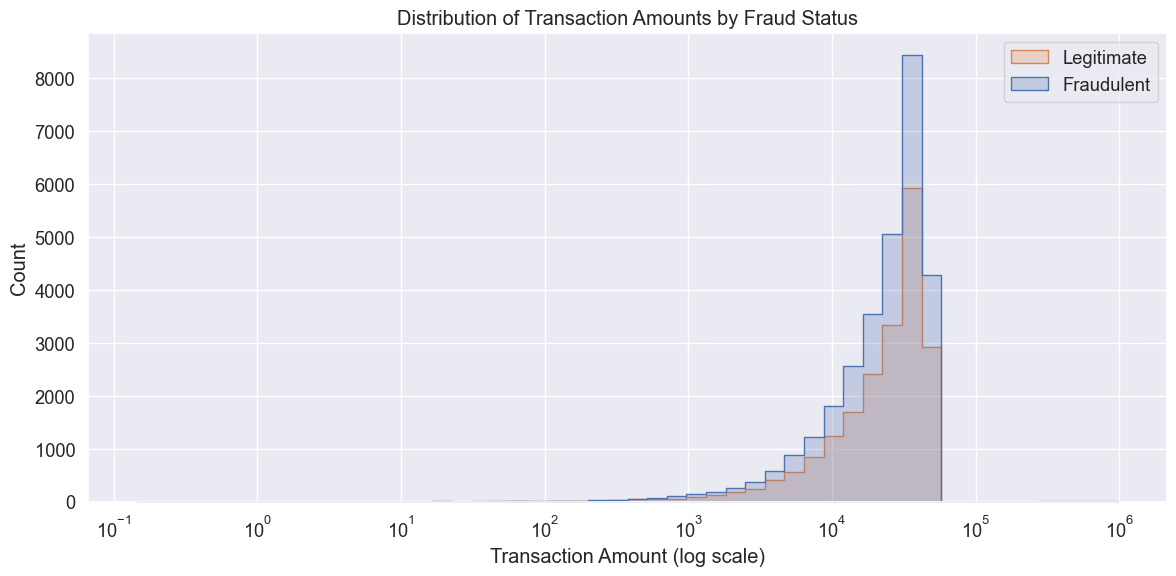

In [33]:
# Analyze the generated data
print("\nAnalyzing the generated data...")

# Set style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Sample data for analysis (to avoid memory issues)
analysis_sample = final_synthetic_data.sample(n=50000)

# 1. Distribution of transaction amounts by fraud status
plt.figure(figsize=(12, 6))
sns.histplot(data=analysis_sample, x='transaction_amount', hue='label_for_fraud', 
             bins=50, log_scale=True, element='step', common_norm=False)
plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('Count')
plt.legend(['Legitimate', 'Fraudulent'])
plt.tight_layout()
plt.savefig('transaction_amount_distribution.png')
plt.show()


<Figure size 1200x600 with 0 Axes>

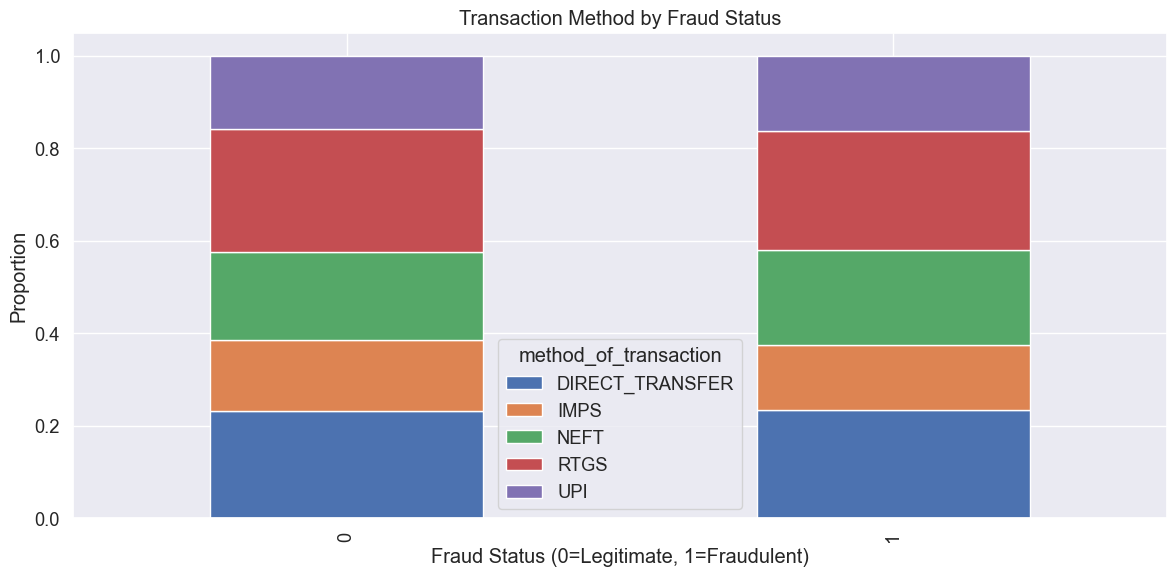

In [34]:

# 2. Transaction method by fraud status
plt.figure(figsize=(12, 6))
fraud_method = pd.crosstab(analysis_sample['label_for_fraud'], analysis_sample['method_of_transaction'], normalize='index')
fraud_method.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Method by Fraud Status')
plt.xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.savefig('transaction_method_by_fraud.png')
plt.show()

<Figure size 1200x600 with 0 Axes>

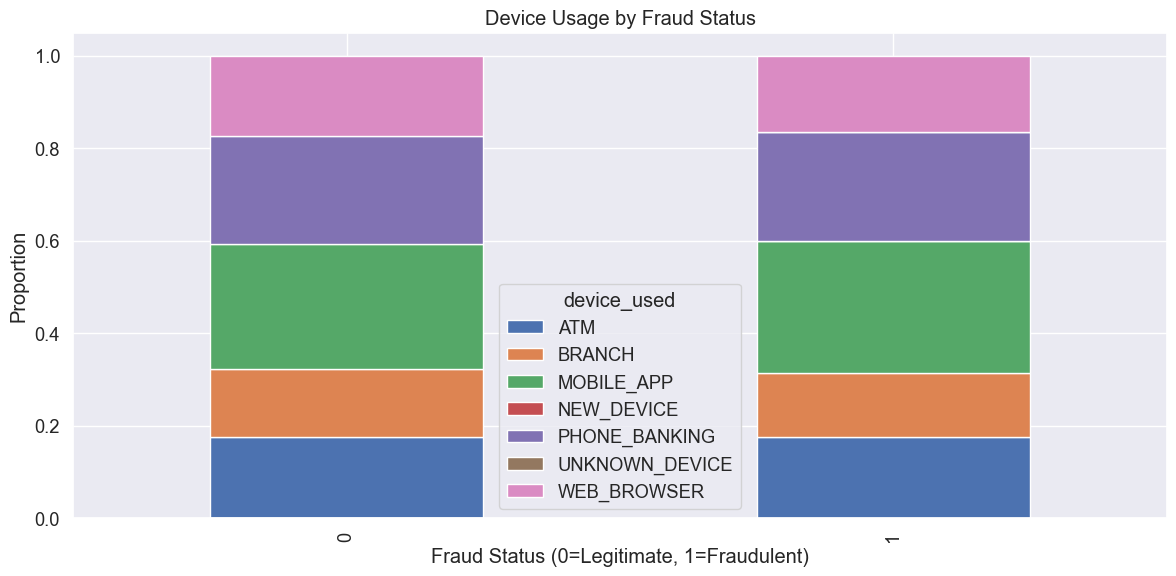

In [35]:


# 3. Device usage by fraud status
plt.figure(figsize=(12, 6))
device_fraud = pd.crosstab(analysis_sample['label_for_fraud'], analysis_sample['device_used'], normalize='index')
device_fraud.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Device Usage by Fraud Status')
plt.xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.savefig('device_usage_by_fraud.png')
plt.show()

<Figure size 1200x600 with 0 Axes>

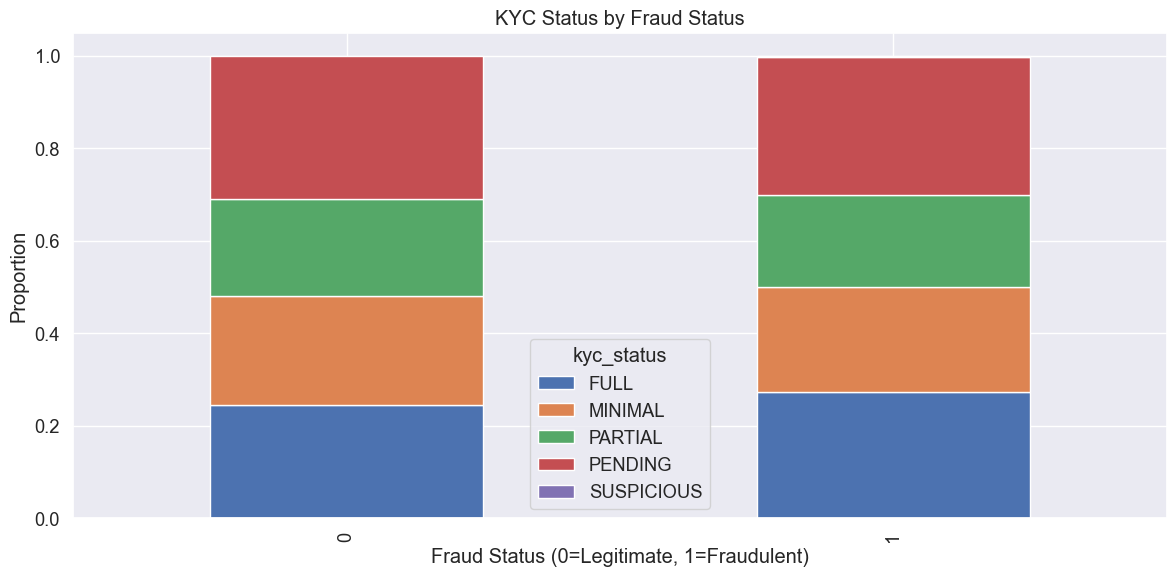

Data generation and analysis completed successfully!


In [36]:


# 4. KYC status by fraud status
plt.figure(figsize=(12, 6))
kyc_fraud = pd.crosstab(analysis_sample['label_for_fraud'], analysis_sample['kyc_status'], normalize='index')
kyc_fraud.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('KYC Status by Fraud Status')
plt.xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.savefig('kyc_status_by_fraud.png')
plt.show()

print("Data generation and analysis completed successfully!")